In [2]:
import pandas as pd
import sqlite3
from sqlite3 import Error 
from sklearn.datasets import load_wine
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
import numpy as np
import plotly.express as px
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
import seaborn as sns

# Getting the data from database and merging population from other data source

In [3]:
def create_connection(path):
    connection = None
    try:
        connection = sqlite3.connect(path)
        print("Connection to SQLite DB successful")
    except Error as e:
        print(f"The error '{e}' occurred")

    return connection

connection = create_connection("twm_banking.sqlite")
customers = pd.read_sql_query("SELECT * FROM customers", connection)

Connection to SQLite DB successful


In [4]:
customers.head()

,index,cust_id,income,age,years_with_bank,nbr_children,gender,marital_status,name_prefix,first_name,last_name,street_nbr,street_name,postal_code,city_name,state_code,full_address,full_name
0,0,1362691,26150,46,5,1,M,2,,Donald,Marek,8298,Second,89194,Las Vegas,NV,8298 Second,Donald Marek
1,1,1362487,6605,71,1,0,M,2,,ChingDyi,Moussavi,10603,Daffodil,90159,Los Angeles,CA,10603 Daffodil,ChingDyi Moussavi
2,2,1363160,18548,38,8,0,F,1,,Rosa,Johnston,8817,Figueroa,90024,Los Angeles,CA,8817 Figueroa,Rosa Johnston
3,3,1362752,47668,54,3,0,F,1,,Lisa,Martin,676,Humble,90172,Los Angeles,CA,676 Humble,Lisa Martin
4,4,1362548,44554,59,9,2,F,4,,Barbara,O'Malley,6578,C,10138,New York City,NY,6578 C,Barbara O'Malley


In [10]:
customers["index_city"] = customers["city_name"]
cities = pd.read_csv("cities.csv", sep = ",")
cities.head()

,Unnamed: 0,index_city,Population
0,309,Pelham,22885
1,310,Thorsby,2044
2,311,Uniontown,2415
3,312,Farmington,6701
4,313,Little Flock,2748


### [source: opendatasoft](https://public.opendatasoft.com/explore/dataset/geonames-all-cities-with-a-population-1000/table/?disjunctive.cou_name_en&sort=name&refine.timezone=America)

In [11]:
custumers_pop = customers.merge(cities, how = 'left')
custumers_pop.shape

(747, 21)

# Exploratory of the numerical features

In [12]:
custumers_num = custumers_pop[["income", "age", "years_with_bank", "nbr_children", "Population"]]

In [13]:
custumers_num.describe()

,income,age,years_with_bank,nbr_children,Population
count,747.000000,747.000000,747.000000,747.000000,0.0
mean,22728.281124,42.479250,3.907631,0.714859,NaN
std,22207.221405,19.114879,2.675634,1.103410,NaN
min,0.000000,13.000000,0.000000,0.000000,NaN
25%,7118.500000,28.000000,2.000000,0.000000,NaN
50%,17242.000000,42.000000,4.000000,0.000000,NaN
75%,31338.000000,56.000000,6.000000,1.000000,NaN
max,144157.000000,89.000000,9.000000,5.000000,NaN


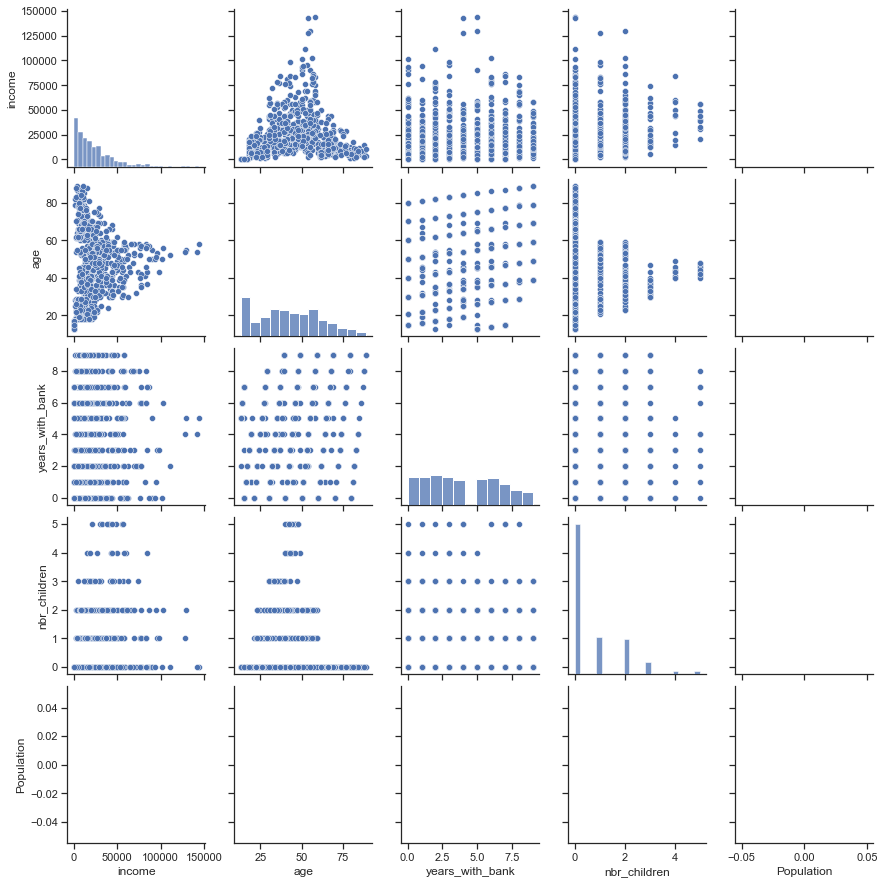

In [9]:
sns.set_theme(style="ticks")
sns.pairplot(custumers_num)

<AxesSubplot:>

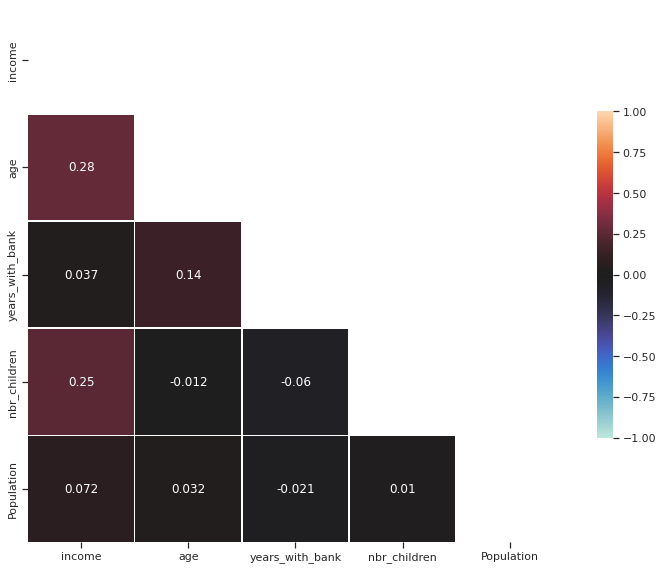

In [49]:
corr = custumers_num.corr()
mask = np.zeros_like(corr, dtype= bool)
mask[np.triu_indices_from(mask)] = True
f, ax = plt.subplots(figsize=(12, 12))
sns.heatmap(
    corr,          # The data to plot
    mask=mask,     # Mask some cells
    annot=True,    # Should the values be plotted in the cells?
    vmax= 1,       # The maximum value of the legend. All higher vals will be same color
    vmin= -1,      # The minimum value of the legend. All lower vals will be same color
    center=0,      # The center value of the legend. With divergent cmap, where white is
    square=True,   # Force cells to be square
    linewidths=.5, # Width of lines that divide cells
    cbar_kws={"shrink": .5}  # Extra kwargs for the legend; in this case, shrink by 50%
)

# Scaling and K-means

In [19]:
scaler = MinMaxScaler(feature_range=(0, 5))
#scaler = StandardScaler()
data_std = scaler.fit_transform(custumers_num)

In [21]:
def plot_distortion(X,max_clusters = 10):
    distortions = []
    for i in range(1, max_clusters +1):
        km = KMeans(n_clusters=i,
                    init='k-means++',
                    n_init=10,
                    random_state=0)
        km.fit(X)
        distortions.append(km.inertia_)

    plt.plot(range(1,max_clusters +1), distortions, marker='o', color='black')
    plt.title('Elbow plot - demographics')
    plt.xlabel('Number of clusters')
    plt.ylabel('Distortion')
    plt.show() 

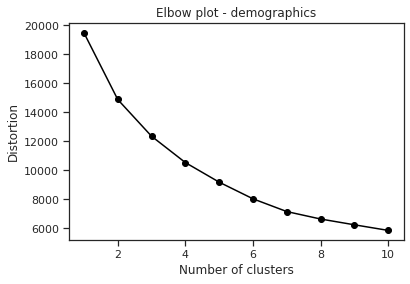

In [154]:
plot_distortion(data_std) # No Elbow! I will call it 4

In [22]:
km = KMeans(n_clusters=4, #number of clusters
           n_init = 10, #how many initial runs
           random_state = 0)

In [23]:
y_km = km.fit_predict(data_std)

In [24]:
groups = pd.DataFrame(y_km)+1
groups.rename(columns = {0:"Group"}, inplace = True)
df_groups = pd.DataFrame(data_std,columns = custumers_num.columns)
df_groups.head()

,income,age,years_with_bank,nbr_children,Population
0,0.906997,2.171053,2.777778,1.0,0.381418
1,0.906997,2.171053,2.777778,1.0,0.008109
2,0.229091,3.815789,0.555556,0.0,2.429206
3,0.643326,1.644737,4.444444,0.0,2.429206
4,1.653336,2.697368,1.666667,0.0,2.429206


In [25]:
df_groups = pd.concat([df_groups,groups], axis = 1)
df_groups.shape

(2183, 6)

# Radar Plot

In [1]:
group_mean_df = df_groups.groupby("Group").mean()

NameError: name 'df_groups' is not defined

In [27]:
import plotly.graph_objects as go
import plotly.offline as pyo

In [28]:
categories = ['Income', 'Age', 'Years with bank', 'Number of children', 'City Population']
categories = [*categories, categories[0]]

In [29]:
Group_1 = list(group_mean_df.iloc[0,:])
Group_2 = list(group_mean_df.iloc[1,:])
Group_3 = list(group_mean_df.iloc[2,:])
Group_4 = list(group_mean_df.iloc[3,:])
Group_1 = [*Group_1, Group_1[0]]
Group_2 = [*Group_2, Group_2[0]]
Group_3 = [*Group_3, Group_3[0]]
Group_4 = [*Group_4, Group_4[0]]

In [180]:
fig = go.Figure(
    data=[
        go.Scatterpolar(r=Group_1, theta=categories, fill='none', name='Group 1'),
        go.Scatterpolar(r=Group_2, theta=categories, fill='none', name='Group 2'),
        go.Scatterpolar(r=Group_3, theta=categories, fill='none', name='Group 3'),
        go.Scatterpolar(r=Group_4, theta=categories, fill='none', name='Group 4')
    ],
    layout=go.Layout(
        title=go.layout.Title(text='Customer Groups'),
        polar={'radialaxis': {'visible': True}},
        showlegend=True
    )
)

pyo.plot(fig)

'temp-plot.html'

# PCA

In [30]:
n_components = 2
pca = PCA(n_components = n_components)
components = pca.fit_transform(data_std)

In [31]:
labels = {
    str(i): f"PC {i+1} ({var:.1f}%)" for i, var in enumerate(pca.explained_variance_ratio_ *100)
}
labels

{'0': 'PC 1 (33.5%)', '1': 'PC 2 (22.5%)'}

In [43]:
df_PCA = pd.DataFrame(components, columns=[f'PC-{i+1}' for i in range(n_components)], index=custumers_pop.index)

In [41]:
 def plot_clusters(X,y_res, plt_cluster_centers = False):
    X_centroids = []
    Y_centroids = []

    for cluster in set(y_res):
        x = X[y_res == cluster]["PC-1"]
        y = X[y_res == cluster]["PC-2"]
        X_centroids.append(np.mean(x))
        Y_centroids.append(np.mean(y))

        plt.scatter(x,
                    y,
                    s=50,
                    marker='s',
                    label=f'cluster {cluster}')

    if plt_cluster_centers:
        plt.scatter(X_centroids,
                    Y_centroids,
                    marker='*',
                    c='red',
                    s=250,
                    label='centroids')
    plt.title('Principal components - demographics')
    plt.xlabel('PC-2')
    plt.ylabel('PC-1')
    plt.legend()
    plt.grid()
    plt.show()

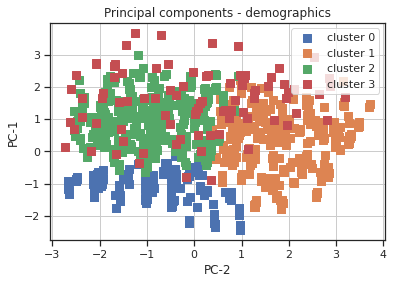

In [42]:
plot_clusters(df_PCA, y_km)

### I did PCA here because the exercise asked for, but as you can see one group (red) is mixed with others, probably because the distinction is in another Principal component.
### It seems to be that using linear discriminant analysis would be better here.